In [1]:
# use dream_proj_env conda env
import pandas as pd
import scanpy as sc 
import os
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr, spearmanr, mannwhitneyu, ttest_ind, ttest_rel, wilcoxon, kruskal, f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random
#import gseapy
from pybiomart import Dataset
import sys
import colorcet as cc
import pickle
from sklearn.utils import Bunch
#import omicverse as ov

# auto reload source files
%load_ext autoreload
%autoreload 2
# add source directory to path
source_path = os.path.abspath(os.path.join('..'))
if source_path not in sys.path:
    sys.path.append(os.path.join(source_path, 'source'))
# read source files
import read_data

%config InlineBackend.figure_format = 'retina'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

magma_categorical = plt.cm.get_cmap('magma', 10)
crest_categorical = plt.cm.get_cmap('crest', 10)
coolwarm_categorical = plt.cm.get_cmap('coolwarm', 10)

# colorpalettes 
hmm = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
fred_again_again_again_palette = ['#000305', '#ff7758', '#f67805', '#d3d3d3', '#565656', '#054fff', '#f9aa74', '#5890ff']
sunset = ['#f3e79b','#fac484','#f8a07e','#eb7f86','#ce6693','#a059a0','#5c53a5']
my_continous_palette = sunset
my_categorical_palette = []
my_categorical_palette.append(hmm[3])
my_categorical_palette.append(fred_again_again_again_palette[-2])
my_categorical_palette.append(hmm[-1])
my_categorical_palette.append(fred_again_again_again_palette[-1])

my_categorical_palette.append(hmm[2])
my_categorical_palette.append(sunset[-1])
my_categorical_palette.append(sunset[-2])
my_categorical_palette.append(sunset[-5])
my_categorical_palette.append(sunset[-7])

organ_palette = {
    "Liver": my_categorical_palette[1],
    "Kidney": my_categorical_palette[2],
    "Brain": my_categorical_palette[5],
}

dream_col = 'DREAM_normalized_enrichment_score_resid'
mut_col = 'mutation_count_per_kb_top50expr'

/tmp/ipykernel_3094188/3799100730.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  magma_categorical = plt.cm.get_cmap('magma', 10)
/tmp/ipykernel_3094188/3799100730.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  crest_categorical = plt.cm.get_cmap('crest', 10)
/tmp/ipykernel_3094188/3799100730.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  coolwarm_categorical = plt.cm.get_cmap('coolwarm', 10)


# TMS

### Other pathway activity

In [2]:
loader = read_data.DatasetLoader("TMS")
tms = loader.load_dataset()

Loading dataset: TMS


In [15]:
import pickle
import pandas as pd

# Define pathways that completed successfully
pathways = [
    "DNMT1", "dream_dr", "dream_other", "E2F7", "FOXM1",
    "dream_expanded_litovchick", "dream_expanded_fischer", "mmb_foxm1", "p53", "rb_e2f"
]

ssgsea_dir = "/cellar/users/zkoch/dream/data/tabula_muris_senis/pathway_ssgsea"

for pathway in pathways:
    with open(f"{ssgsea_dir}/{pathway}_ssgsea_combined.pkl", "rb") as f:
        pathway_df = pickle.load(f)

    # Use cell_index to align with dream_expression.obs
    pathway_df = pathway_df.set_index('cell_index')

    # Add columns to dream_expression.obs (missing cells will be NaN)
    for col in pathway_df.columns:
        tms.dream_expression.obs[col] = pathway_df[col].reindex(range(len(tms.dream_expression.obs))).values

    print(f"Added {pathway}: {list(pathway_df.columns)}")

# Check how many NaNs (should be 824)
print(f"\nNaN count in DNMT1_NES: {tms.dream_expression.obs['DNMT1_NES'].isna().sum()}")

Added DNMT1: ['DNMT1_ES', 'DNMT1_NES', 'DNMT1_NES_resid', 'DNMT1_ES_resid']
Added dream_dr: ['dream_dr_ES', 'dream_dr_NES', 'dream_dr_NES_resid', 'dream_dr_ES_resid']
Added dream_other: ['dream_other_ES', 'dream_other_NES', 'dream_other_NES_resid', 'dream_other_ES_resid']
Added E2F7: ['E2F7_ES', 'E2F7_NES', 'E2F7_NES_resid', 'E2F7_ES_resid']
Added FOXM1: ['FOXM1_ES', 'FOXM1_NES', 'FOXM1_NES_resid', 'FOXM1_ES_resid']
Added dream_expanded_litovchick: ['dream_expanded_litovchick_ES', 'dream_expanded_litovchick_NES', 'dream_expanded_litovchick_NES_resid', 'dream_expanded_litovchick_ES_resid']
Added dream_expanded_fischer: ['dream_expanded_fischer_ES', 'dream_expanded_fischer_NES', 'dream_expanded_fischer_NES_resid', 'dream_expanded_fischer_ES_resid']
Added mmb_foxm1: ['mmb_foxm1_ES', 'mmb_foxm1_NES', 'mmb_foxm1_NES_resid', 'mmb_foxm1_ES_resid']
Added p53: ['p53_ES', 'p53_NES', 'p53_NES_resid', 'p53_ES_resid']
Added rb_e2f: ['rb_e2f_ES', 'rb_e2f_NES', 'rb_e2f_NES_resid', 'rb_e2f_ES_resid']


In [84]:
import statsmodels.formula.api as smf
from scipy.stats import zscore

def calc_tms_regression_association(
    obs_df,
    pathway_names,
    target_col,
    dream_col='DREAM_normalized_enrichment_score_resid',
    group_col='tissue',
    standardize=True
):
    """
    Calculate OLS regression associations between mutation burden and pathway activities
    for TMS single-cell data.
    
    For each pathway:
    1. Runs pathway alone: target ~ pathway
    2. Runs pathway + DREAM: target ~ DREAM + pathway (extracts DREAM coefficient)
    
    Parameters:
        obs_df: DataFrame with pathway scores and target variable (e.g., tms.dream_expression.obs)
        pathway_names: List of pathway column names to test
        target_col: Target variable column name (mutation burden)
        dream_col: DREAM pathway column name
        group_col: Column to group by (default: 'tissue')
        standardize: If True, z-score standardize predictors for comparable coefficients
        
    Returns:
        results_long: Long-format DataFrame with coefficients and p-values
        results_pivot: Wide-format DataFrame for easier viewing
    """
    # Filter to available pathways
    pathway_names = [p for p in pathway_names if p in obs_df.columns]

    results = []

    for group in obs_df[group_col].unique():
        group_df = obs_df.query(f"{group_col} == @group").copy()

        # Get columns needed
        cols_needed = [target_col, dream_col] + pathway_names
        cols_needed = list(dict.fromkeys(c for c in cols_needed if c in group_df.columns))       
        group_df = group_df[cols_needed].dropna()

        if len(group_df) < 10:  # Skip groups with too few samples
            continue

        # Z-score standardize predictors
        if standardize:
            for col in cols_needed:
                if col != target_col and group_df[col].std() > 0:
                    group_df[col] = zscore(group_df[col])

        # Rename columns to be formula-friendly
        rename_map = {col: col.replace('-', '_').replace(' ', '_').replace('.', '_')
                    for col in group_df.columns}
        group_df = group_df.rename(columns=rename_map)
        target_clean = rename_map.get(target_col, target_col)
        dream_clean = rename_map.get(dream_col, dream_col)

        for pathway in pathway_names:
            pathway_clean = rename_map.get(pathway, pathway)

            if pathway_clean not in group_df.columns:
                continue

            # Model 1: target ~ pathway (solo)
            try:
                formula_solo = f'Q("{target_clean}") ~ Q("{pathway_clean}")'
                model_solo = smf.ols(formula=formula_solo, data=group_df).fit()
                solo_coef = model_solo.params[f'Q("{pathway_clean}")']
                solo_pval = model_solo.pvalues[f'Q("{pathway_clean}")']
                solo_rsq = model_solo.rsquared
                solo_n = int(model_solo.nobs)
            except Exception:
                solo_coef, solo_pval, solo_rsq, solo_n = np.nan, np.nan, np.nan, np.nan

            results.append({
                group_col: group,
                'pathway': pathway,
                'model_type': 'solo',
                'extracted_variable': pathway,
                'coefficient': solo_coef,
                'pvalue': solo_pval,
                'rsquared': solo_rsq,
                'n_samples': solo_n
            })

            # Model 2: target ~ DREAM + pathway (only for non-DREAM pathways)
            if pathway != dream_col:
                try:
                    formula_combo = f'Q("{target_clean}") ~ Q("{dream_clean}") + Q("{pathway_clean}")'
                    model_combo = smf.ols(formula=formula_combo, data=group_df).fit()

                    # Extract DREAM coefficient
                    dream_coef = model_combo.params[f'Q("{dream_clean}")']
                    dream_pval = model_combo.pvalues[f'Q("{dream_clean}")']

                    # Also extract pathway coefficient from combo model
                    pathway_coef_combo = model_combo.params[f'Q("{pathway_clean}")']
                    pathway_pval_combo = model_combo.pvalues[f'Q("{pathway_clean}")']

                    combo_rsq = model_combo.rsquared
                    combo_n = int(model_combo.nobs)
                except Exception:
                    dream_coef, dream_pval = np.nan, np.nan
                    pathway_coef_combo, pathway_pval_combo = np.nan, np.nan
                    combo_rsq, combo_n = np.nan, np.nan

                # DREAM's coefficient when controlling for this pathway
                results.append({
                    group_col: group,
                    'pathway': pathway,
                    'model_type': 'with_DREAM',
                    'extracted_variable': dream_col,
                    'coefficient': dream_coef,
                    'pvalue': dream_pval,
                    'rsquared': combo_rsq,
                    'n_samples': combo_n
                })

                # Pathway's coefficient when controlling for DREAM
                results.append({
                    group_col: group,
                    'pathway': pathway,
                    'model_type': 'with_DREAM',
                    'extracted_variable': pathway,
                    'coefficient': pathway_coef_combo,
                    'pvalue': pathway_pval_combo,
                    'rsquared': combo_rsq,
                    'n_samples': combo_n
                })

    results_df = pd.DataFrame(results)

    # Create pivot table for easier viewing
    pivot_df = results_df.pivot_table(
        index=[group_col, 'pathway'],
        columns='model_type',
        values=['coefficient', 'pvalue', 'rsquared'],
        aggfunc='first'
    )
    pivot_df.columns = [f'{stat}_{model}' for stat, model in pivot_df.columns]
    pivot_df = pivot_df.reset_index()

    return results_df, pivot_df

from scipy.stats import wilcoxon

def plot_dream_coefficients_boxplot(
    results_long, 
    dream_pathways,
    solo_pathways, 
    dream_combo_pathways,
    group_col='tissue',
    figsize=(12, 5),
    dream_color=my_categorical_palette[0],
    solo_color=my_categorical_palette[1],
    combo_color=my_categorical_palette[2],
    dream_col='DREAM_normalized_enrichment_score_resid'
):
    """
    Plot pathway coefficient distributions across tissues as boxplots.

    Parameters:
        results_long: Long-format DataFrame from calc_tms_regression_association
        dream_pathways: List of DREAM pathways to plot (from solo models)
        solo_pathways: List of pathways to plot their own coefficient (from solo models)
        dream_combo_pathways: List of pathways - will plot DREAM's coefficient when controlling for these
        group_col: Column name for grouping (default: 'tissue')
        figsize: Figure size tuple
        dream_color: Color for DREAM pathway boxes
        solo_color: Color for solo pathway boxes
        combo_color: Color for DREAM combo boxes
        dream_col: Name of DREAM column for filtering combo results

    Returns:
        fig, axes
    """
    # Set default colors if not provided
    if dream_color is None:
        dream_color = sns.color_palette()[0]
    if solo_color is None:
        solo_color = sns.color_palette()[1]
    if combo_color is None:
        combo_color = sns.color_palette()[2]

    fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=False)

    # Helper function to clean pathway names
    def clean_name(pathway):
        # map pathways to their cleaned names
        mapper = {
            'DREAM_normalized_enrichment_score_resid': 'DREAM',
            'DNMT1_NES_resid': 'DNMT1',
            'dream_dr_NES_resid': 'DREAM (DNA Repair)', 
            'dream_other_NES_resid': 'DREAM (Other)', 
            'E2F7_NES_resid': 'E2F7',
            'FOXM1_NES_resid': 'FOXM1', 
            'dream_expanded_fischer_NES_resid': 'DREAM expanded (Fischer)',
            'dream_expanded_litovchick_NES_resid': 'DREAM expanded (Litovchick)', 
            'mmb_foxm1_NES_resid': 'MMB-FOXM1',
            'p53_NES_resid': 'p53', 
            'rb_e2f_NES_resid': 'RB-E2F'
        }
        return mapper[pathway]

    # Helper function to test if median differs from zero using Wilcoxon signed-rank test
    def test_median_vs_zero(values):
        """Test if distribution median differs from zero using Wilcoxon signed-rank test."""
        values = values.dropna()
        if len(values) < 5:
            return np.nan
        try:
            # Wilcoxon signed-rank test for testing median against zero
            stat, pval = wilcoxon(values)
            return pval
        except Exception:
            return np.nan

    # Helper function to add significance stars
    def add_stars(ax, x, y, pval, y_range):
        if pd.isna(pval):
            return
        if pval < 0.001:
            star = '***'
        elif pval < 0.01:
            star = '**'
        elif pval < 0.05:
            star = '*'
        else:
            star = ''
        if star:
            offset = 0.03 * y_range
            ax.text(x, y + offset, star, ha='center', va='bottom', fontsize=10)

    # --- Collect data for each subplot ---

    # DREAM pathways data (solo models)
    dream_df = results_long.query(
        "model_type == 'solo' and pathway in @dream_pathways"
    ).copy()
    dream_df['clean_name'] = dream_df['pathway'].apply(clean_name)

    # Calculate p-values for each pathway
    dream_pvals = {}
    if len(dream_df) > 0:
        for pathway in dream_df['clean_name'].unique():
            vals = dream_df.query("clean_name == @pathway")['coefficient']
            dream_pvals[pathway] = test_median_vs_zero(vals)

        # Sort by median coefficient (keep first pathway first)
        pathway_order = dream_df.groupby('clean_name')['coefficient'].median().sort_values(ascending=False).index.tolist()
        first_clean = clean_name(dream_pathways[0])
        if first_clean in pathway_order:
            pathway_order.remove(first_clean)
            pathway_order = [first_clean] + pathway_order
        dream_df['clean_name'] = pd.Categorical(dream_df['clean_name'], categories=pathway_order, ordered=True)

    # Solo pathways data (non-DREAM, solo models)
    solo_df = results_long.query(
        "model_type == 'solo' and pathway in @solo_pathways"
    ).copy()
    solo_df['clean_name'] = solo_df['pathway'].apply(clean_name)

    solo_pvals = {}
    if len(solo_df) > 0:
        for pathway in solo_df['clean_name'].unique():
            vals = solo_df.query("clean_name == @pathway")['coefficient']
            solo_pvals[pathway] = test_median_vs_zero(vals)

        pathway_order = solo_df.groupby('clean_name')['coefficient'].median().sort_values(ascending=False).index.tolist()
        solo_df['clean_name'] = pd.Categorical(solo_df['clean_name'], categories=pathway_order, ordered=True)

    # Combo data - DREAM's coefficient when controlling for other pathways
    combo_df = results_long.query(
        "model_type == 'with_DREAM' and pathway in @dream_combo_pathways and extracted_variable == @dream_col"
    ).copy()
    combo_df['clean_name'] = combo_df['pathway'].apply(lambda x: f"DREAM + {clean_name(x)}")

    combo_pvals = {}
    if len(combo_df) > 0:
        for pathway in combo_df['clean_name'].unique():
            vals = combo_df.query("clean_name == @pathway")['coefficient']
            combo_pvals[pathway] = test_median_vs_zero(vals)

        pathway_order = combo_df.groupby('clean_name')['coefficient'].median().sort_values(ascending=False).index.tolist()
        combo_df['clean_name'] = pd.Categorical(combo_df['clean_name'], categories=pathway_order, ordered=True)

    # --- Determine shared y-axis limits ---
    all_coefs = pd.concat([
        dream_df['coefficient'] if len(dream_df) > 0 else pd.Series(dtype=float),
        solo_df['coefficient'] if len(solo_df) > 0 else pd.Series(dtype=float),
        combo_df['coefficient'] if len(combo_df) > 0 else pd.Series(dtype=float)
    ]).dropna()

    if len(all_coefs) > 0:
        y_min = all_coefs.min()
        y_max = all_coefs.max()
        y_range = y_max - y_min
        y_min_padded = y_min - 0.1 * y_range
        y_max_padded = y_max + 0.15 * y_range  # Extra space for stars
    else:
        y_min_padded, y_max_padded = -1, 1

    y_range = y_max_padded - y_min_padded

    # --- Subplot 0: DREAM pathways ---
    ax0 = axes[0]
    if len(dream_df) > 0:
        sns.boxplot(
            data=dream_df,
            x='clean_name',
            y='coefficient',
            color=dream_color,
            ax=ax0
        )
        # Add significance stars
        categories = dream_df['clean_name'].cat.categories.tolist()
        for i, cat in enumerate(categories):
            max_val = dream_df.query("clean_name == @cat")['coefficient'].max()
            pval = dream_pvals.get(cat, np.nan)
            add_stars(ax0, i, max_val, pval, y_range)

    ax0.set_xlabel('')
    ax0.set_ylabel('Association of mutation burden\nwith pathway activity')
    ax0.set_xticklabels(ax0.get_xticklabels(), rotation=90)
    ax0.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

    # --- Subplot 1: Solo pathway coefficients ---
    ax1 = axes[1]
    if len(solo_df) > 0:
        sns.boxplot(
            data=solo_df,
            x='clean_name',
            y='coefficient',
            color=solo_color,
            ax=ax1
        )
        # Add significance stars
        categories = solo_df['clean_name'].cat.categories.tolist()
        for i, cat in enumerate(categories):
            max_val = solo_df.query("clean_name == @cat")['coefficient'].max()
            pval = solo_pvals.get(cat, np.nan)
            add_stars(ax1, i, max_val, pval, y_range)

    ax1.set_xlabel('')
    ax1.set_ylabel('Association of mutation burden\nwith pathway activity')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

    # --- Subplot 2: DREAM coefficients from combo models ---
    ax2 = axes[2]
    if len(combo_df) > 0:
        sns.boxplot(
            data=combo_df,
            x='clean_name',
            y='coefficient',
            color=combo_color,
            ax=ax2
        )
        # Add significance stars
        categories = combo_df['clean_name'].cat.categories.tolist()
        for i, cat in enumerate(categories):
            max_val = combo_df.query("clean_name == @cat")['coefficient'].max()
            pval = combo_pvals.get(cat, np.nan)
            add_stars(ax2, i, max_val, pval, y_range)

    ax2.set_xlabel('')
    ax2.set_ylabel('Association of mutation burden\nwith pathway activity')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

    # Set shared y-axis limits
    for ax in axes:
        ax.set_ylim(y_min_padded, y_max_padded)

    sns.despine()
    plt.tight_layout()

    return fig, axes

/tmp/ipykernel_3094188/752753847.py:327: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax0.set_xticklabels(ax0.get_xticklabels(), rotation=90)
/tmp/ipykernel_3094188/752753847.py:349: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/tmp/ipykernel_3094188/752753847.py:371: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
/tmp/ipykernel_3094188/1555967476.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha = 'right')
/tmp/ipykernel_3094188/1555967476.py:60: UserWarning: set_ticklabels() should on

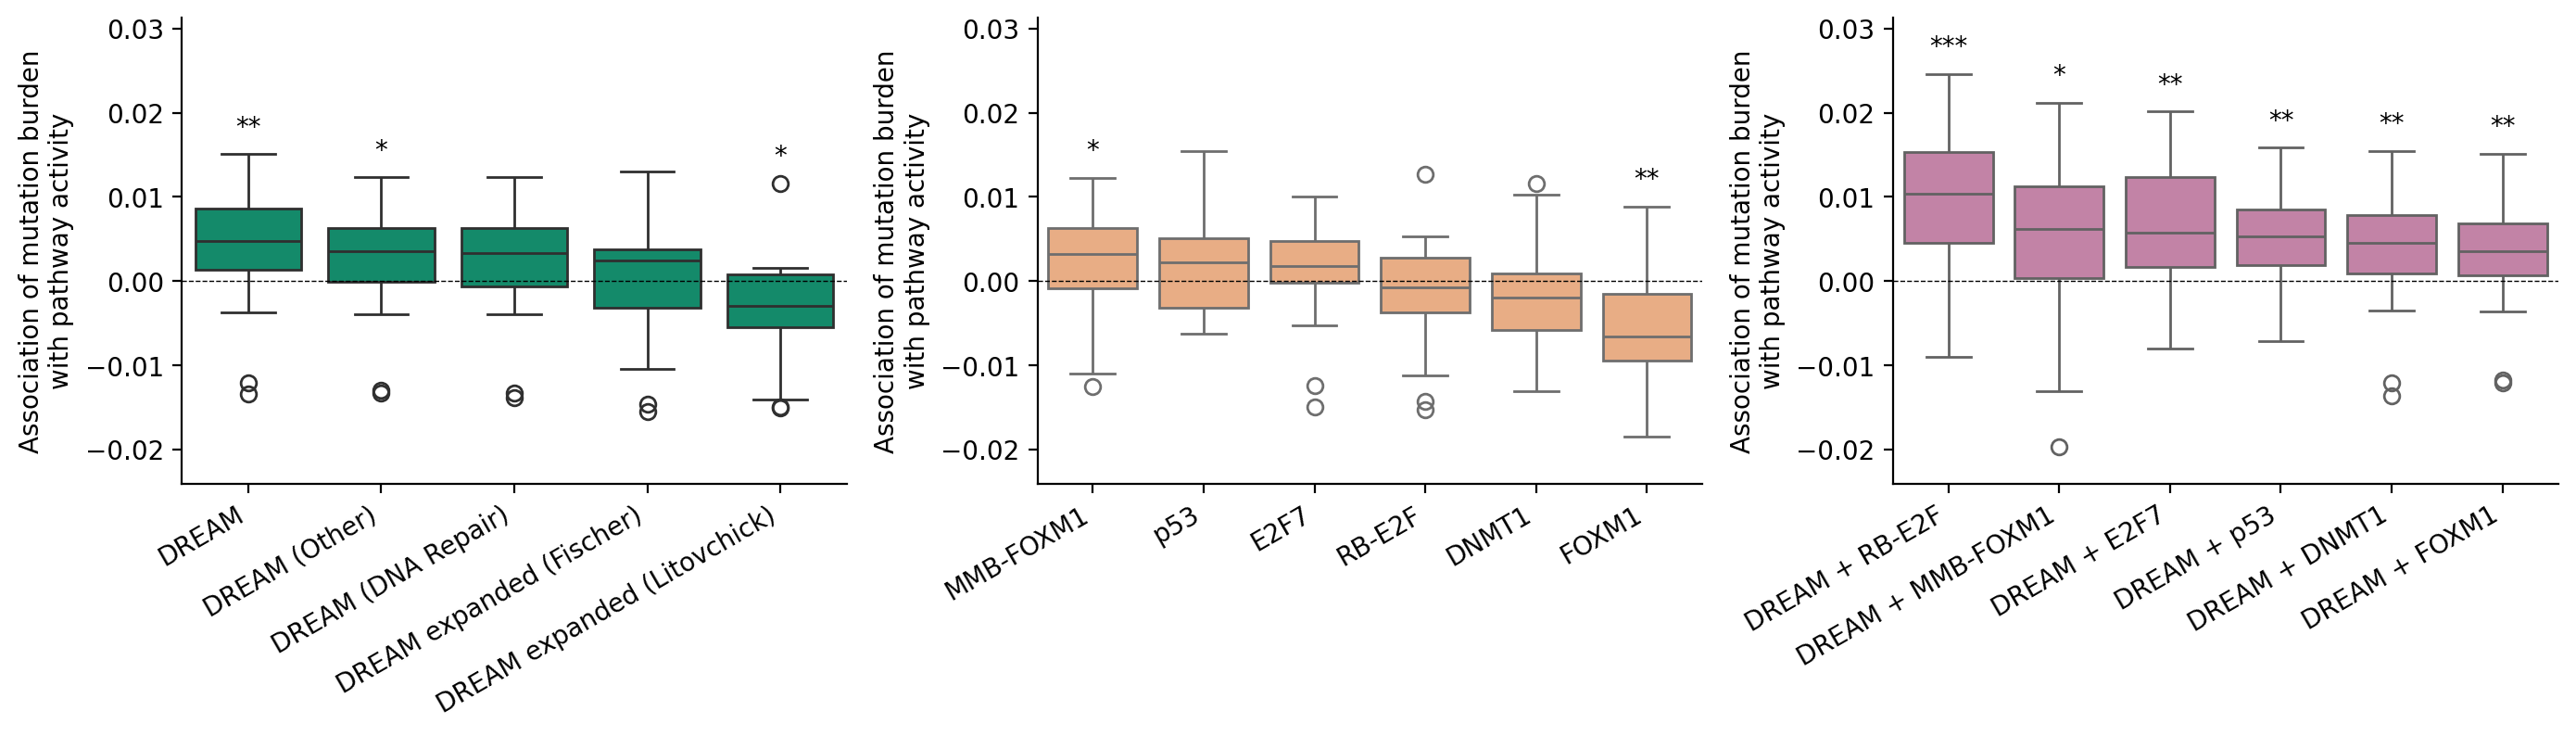

In [85]:
# Usage:
pathway_names = [
    'DREAM_normalized_enrichment_score_resid',
    'DNMT1_NES_resid',
    'dream_dr_NES_resid',
    'dream_other_NES_resid',
    'E2F7_NES_resid',
    'FOXM1_NES_resid',
    'dream_expanded_fischer_NES_resid',
    'dream_expanded_litovchick_NES_resid',
    'mmb_foxm1_NES_resid',
    'p53_NES_resid',
    'rb_e2f_NES_resid'
]

results_long, results_pivot = calc_tms_regression_association(
    obs_df=tms.dream_expression.obs,
    pathway_names=pathway_names,
    target_col=mut_col,
    dream_col='DREAM_normalized_enrichment_score_resid',
    group_col='tissue',
    standardize=True
)

DREAM_pathways = [
    'DREAM_normalized_enrichment_score_resid',
    'dream_dr_NES_resid',
    'dream_other_NES_resid',
    'dream_expanded_fischer_NES_resid',
    'dream_expanded_litovchick_NES_resid',
]

solo_pathways = [
    'mmb_foxm1_NES_resid',
    'p53_NES_resid',
    'rb_e2f_NES_resid',
    'DNMT1_NES_resid',
    'E2F7_NES_resid',
    'FOXM1_NES_resid'
]

dream_combo_pathways = [
    'mmb_foxm1_NES_resid',
    'p53_NES_resid',
    'rb_e2f_NES_resid',
    'DNMT1_NES_resid',
    'E2F7_NES_resid',
    'FOXM1_NES_resid'
]

fig, axes = plot_dream_coefficients_boxplot(
    results_long,
    dream_pathways=DREAM_pathways,
    solo_pathways=solo_pathways,
    dream_combo_pathways=dream_combo_pathways,
    group_col='tissue',
    figsize=(14, 5)
)
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha = 'right')
plt.show()

fig.savefig('/cellar/users/zkoch/dream/figures/supplementary/revision_upset/tms_mutation_assoc.svg', dpi=300)


### DNA repair genes in high-vs-low DREAM